In [1]:
import kan
import kan.utils as ku
import torch
import torch.nn as nn
import numpy as np
from libraries import utils
from libraries import magnetization
from libraries import j1j2_functions
import numpy.random as npr
import qutip as qt
import sympy
import random

In [2]:
J1=1

In [3]:
def get_nonzero_states(N, gs, threshold):
    states = []
    signs = []
    for i in range(0, 2**N):
        val = gs[i][0].real
        if abs(val) > threshold:
            states.append(i)
            signs.append(-1 + 2 * int(val > 0))
    return states, signs

def find_deviations(states, signs, pred_signs):
    dev_forward = []
    for state, true, calc in zip(states, signs, pred_signs):
        if true != calc:
            dev_forward.append(state)
    
    dev_rev = []
    for state, true, calc in zip(states, signs, pred_signs):
        if true != -calc:
            dev_rev.append(state)
    if len(dev_rev) > len(dev_forward):
        return dev_forward
    return dev_rev

In [4]:
def rotate_right(state,rotations,N):
    return (2**N-1)&(state>>rotations|state<<(N-rotations))

In [5]:
def find_uniques(states, N):
    def found(uniques, state, N):
            for u in uniques:
                for rots in range(N):
                    if u == rotate_right(state, rots, N):
                        return u
            return False

    uniques = {}
    for state in states:
        f = found(uniques, state, N)
        if isinstance(f, bool):
            uniques[state] = 1
        else:
            uniques[f] += 1
    return uniques

In [6]:
threshold = 1e-12
dev_data = {}
for N in [6, 8, 10]:
    if N == 10:
        gsz = qt.qload(f'N{N}/n{N}gs_J2_0.0')
    else:
        hz = j1j2_functions.J1J2_hamiltonian(N, J1, 0)
        eigsz = hz.eigenstates()
        gsz = eigsz[1][0]
    
    statesz, signsz = get_nonzero_states(N, gsz, threshold)
    pred_signsz =  [-1 + 2 * (magnetization.count_half_magnetization(i) % 2) for i in statesz]
    deviationsz = find_deviations(statesz, signsz, pred_signsz)

    for J2 in [0.1, 0.2, 0.3, 0.4, 0.495]:
        print(N, J2)
        if N == 10:
            gsf = qt.qload(f'N{N}/n{N}gs_J2_{round(J2, 3)}')
        else:
            hf = j1j2_functions.J1J2_hamiltonian(N, J1, J2)
            eigsf = hf.eigenstates()
            gsf = eigsf[1][0]

        statesf, signsf = get_nonzero_states(N, gsf, threshold)
        pred_signsf =  [-1 + 2 * (magnetization.count_half_magnetization(i) % 2) for i in statesf]
        deviationsf = find_deviations(statesf, signsf, pred_signsf)

        print('num nonzero', len(statesz), len(statesf), 'equal', statesz == statesf)
        print('J2=0 deviations', len(deviationsz))
        print('J2>0 deviations', len(deviationsf))
        dev_data[(N, J2)] = deviationsf

6 0.1
num nonzero 20 20 equal True
J2=0 deviations 0
J2>0 deviations 0
6 0.2
num nonzero 20 20 equal True
J2=0 deviations 0
J2>0 deviations 0
6 0.3
num nonzero 20 20 equal True
J2=0 deviations 0
J2>0 deviations 0
6 0.4
num nonzero 20 20 equal True
J2=0 deviations 0
J2>0 deviations 0
6 0.495
num nonzero 20 20 equal True
J2=0 deviations 0
J2>0 deviations 0
8 0.1
num nonzero 70 70 equal True
J2=0 deviations 0
J2>0 deviations 0
8 0.2
num nonzero 70 70 equal True
J2=0 deviations 0
J2>0 deviations 0
8 0.3
num nonzero 70 70 equal True
J2=0 deviations 0
J2>0 deviations 8
8 0.4
num nonzero 70 70 equal True
J2=0 deviations 0
J2>0 deviations 8
8 0.495
num nonzero 70 70 equal True
J2=0 deviations 0
J2>0 deviations 8
10 0.1
num nonzero 252 252 equal True
J2=0 deviations 0
J2>0 deviations 0
10 0.2
num nonzero 252 252 equal True
J2=0 deviations 0
J2>0 deviations 10
10 0.3
num nonzero 252 252 equal True
J2=0 deviations 0
J2>0 deviations 70
10 0.4
num nonzero 252 252 equal True
J2=0 deviations 0
J2>0 d

In [7]:
for N in [6, 8, 10]:
    for J2 in [0.1, 0.2, 0.3, 0.4, 0.495]:
        print(N, J2)
        uniques = find_uniques(dev_data[(N, J2)], N)
        print('len', len(uniques))
        for u in uniques:
            print(bin(u))
        print()

6 0.1
len 0

6 0.2
len 0

6 0.3
len 0

6 0.4
len 0

6 0.495
len 0

8 0.1
len 0

8 0.2
len 0

8 0.3
len 1
0b1111

8 0.4
len 1
0b1111

8 0.495
len 1
0b1111

10 0.1
len 0

10 0.2
len 1
0b11111

10 0.3
len 7
0b11111
0b101111
0b110111
0b111011
0b111101
0b1001111
0b1111001

10 0.4
len 6
0b101111
0b110111
0b111011
0b111101
0b1001111
0b1111001

10 0.495
len 6
0b101111
0b110111
0b111011
0b111101
0b1001111
0b1111001



In [8]:
J2s = np.linspace(0, 0.5-0.005, 100)# [0.2  , 0.205, 0.21 , 0.215, 0.22 ,
#        0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
#        0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
#        0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
#        0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4 ]

In [18]:
threshold = 1e-12
dev_data_10 = {}
N = 10
gsz = qt.qload('N10/n10gs_J2_0.0')

statesz, signsz = get_nonzero_states(N, gsz, threshold)
pred_signsz =  [-1 + 2 * (magnetization.count_half_magnetization(i) % 2) for i in statesz]
deviationsz = find_deviations(statesz, signsz, pred_signsz)

for J2 in J2s:
    print(N, J2)
    gsf = qt.qload(f'N10/n10gs_J2_{round(J2, 3)}')
    statesf, signsf = get_nonzero_states(N, gsf, threshold)
    pred_signsf =  [-1 + 2 * (magnetization.count_half_magnetization(i) % 2) for i in statesf]
    deviationsf = find_deviations(statesf, signsf, pred_signsf)

    print('num nonzero', len(statesf), 'equal', statesz == statesf)
    print('J2>0 deviations', len(deviationsf))
    dev_data_10[(N, J2)] = deviationsf

10 0.0
num nonzero 252 equal True
J2>0 deviations 0
10 0.005
num nonzero 252 equal True
J2>0 deviations 0
10 0.01
num nonzero 252 equal True
J2>0 deviations 0
10 0.015
num nonzero 252 equal True
J2>0 deviations 0
10 0.02
num nonzero 252 equal True
J2>0 deviations 0
10 0.025
num nonzero 252 equal True
J2>0 deviations 0
10 0.03
num nonzero 252 equal True
J2>0 deviations 0
10 0.035
num nonzero 252 equal True
J2>0 deviations 0
10 0.04
num nonzero 252 equal True
J2>0 deviations 0
10 0.045
num nonzero 252 equal True
J2>0 deviations 0
10 0.05
num nonzero 252 equal True
J2>0 deviations 0
10 0.055
num nonzero 252 equal True
J2>0 deviations 0
10 0.06
num nonzero 252 equal True
J2>0 deviations 0
10 0.065
num nonzero 252 equal True
J2>0 deviations 0
10 0.07
num nonzero 252 equal True
J2>0 deviations 0
10 0.075
num nonzero 252 equal True
J2>0 deviations 0
10 0.08
num nonzero 252 equal True
J2>0 deviations 0
10 0.085
num nonzero 252 equal True
J2>0 deviations 0
10 0.09
num nonzero 252 equal True
J2>

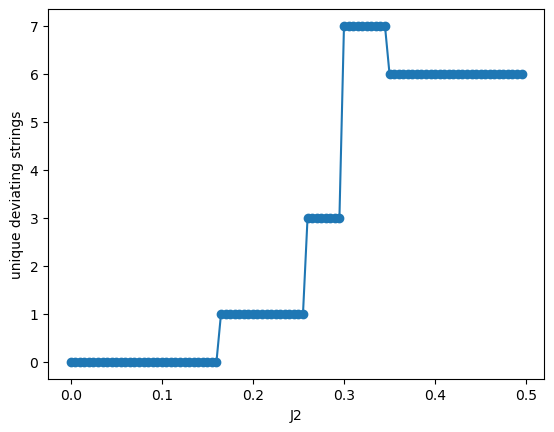

In [21]:
import matplotlib.pyplot as plt
len_uniques = []
for J2 in J2s:
    uniques = find_uniques(dev_data_10[10, J2], N)
    len_uniques.append(len(uniques))
plt.plot(J2s, len_uniques)
plt.scatter(J2s, len_uniques)
plt.xlabel('J2')
plt.ylabel('unique deviating strings')
plt.show()

In [11]:
uniques = find_uniques(dev_data_10[(10, 0.28)], N)
print(len(uniques))
for u in uniques:
    print(bin(u))

3
0b11111
0b101111
0b111101


In [29]:
threshold = 1e-12
dev_data_8 = {}
N = 8
gsz = qt.qload(f'N{N}/n{N}gs_J2_0.0')

statesz, signsz = get_nonzero_states(N, gsz, threshold)
pred_signsz =  [-1 + 2 * (magnetization.count_half_magnetization(i) % 2) for i in statesz]
deviationsz = find_deviations(statesz, signsz, pred_signsz)

for J2 in J2s:#[0.1, 0.2, 0.3, 0.4, 0.495]:
    #print(N, J2)
    gsf = qt.qload(f'N{N}/n{N}gs_J2_{round(J2, 3)}')
    statesf, signsf = get_nonzero_states(N, gsf, threshold)
    pred_signsf =  [-1 + 2 * (magnetization.count_half_magnetization(i) % 2) for i in statesf]
    deviationsf = find_deviations(statesf, signsf, pred_signsf)

    #print('num nonzero', len(statesf), 'equal', statesz == statesf)
    #print('J2>0 deviations', len(deviationsf))
    dev_data_8[(N, J2)] = deviationsf

In [23]:
threshold = 1e-12
dev_data_12 = {}
N = 12
gsz = qt.qload(f'N{N}/n{N}gs_J2_0')

statesz, signsz = get_nonzero_states(N, gsz, threshold)
pred_signsz =  [-1 + 2 * (magnetization.count_half_magnetization(i) % 2) for i in statesz]
deviationsz = find_deviations(statesz, signsz, pred_signsz)

for J2 in J2s:#[0.1, 0.2, 0.3, 0.4, 0.495]:
    #print(N, J2)
    gsf = qt.qload(f'N{N}/n{N}gs_J2_{round(J2, 3)}')
    statesf, signsf = get_nonzero_states(N, gsf, threshold)
    pred_signsf =  [-1 + 2 * (magnetization.count_half_magnetization(i) % 2) for i in statesf]
    deviationsf = find_deviations(statesf, signsf, pred_signsf)

    #print('num nonzero', len(statesf), 'equal', statesz == statesf)
    #print('J2>0 deviations', len(deviationsf))
    dev_data_12[(N, J2)] = deviationsf

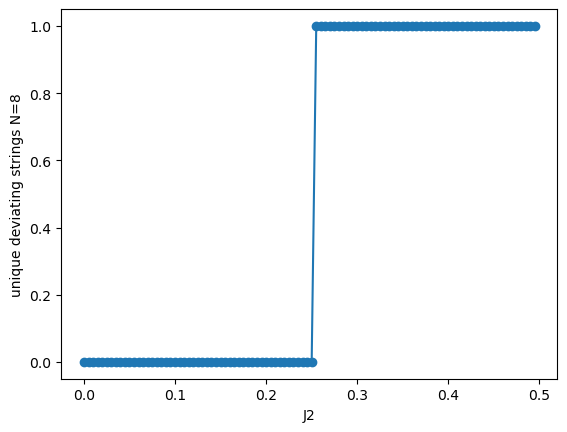

In [31]:
len_uniques_8 = []
for J2 in J2s:
    uniques = find_uniques(dev_data_8[8, J2], N)
    len_uniques_8.append(len(uniques))
plt.plot(J2s, len_uniques_8)
plt.scatter(J2s, len_uniques_8)
plt.xlabel('J2')
plt.ylabel('unique deviating strings N=8')
plt.show()

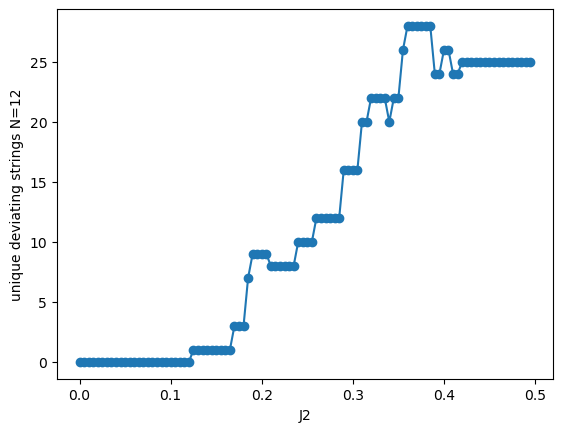

In [24]:
len_uniques_12 = []
for J2 in J2s:
    uniques = find_uniques(dev_data_12[12, J2], N)
    len_uniques_12.append(len(uniques))
plt.plot(J2s, len_uniques_12)
plt.scatter(J2s, len_uniques_12)
plt.xlabel('J2')
plt.ylabel('unique deviating strings N=12')
plt.show()

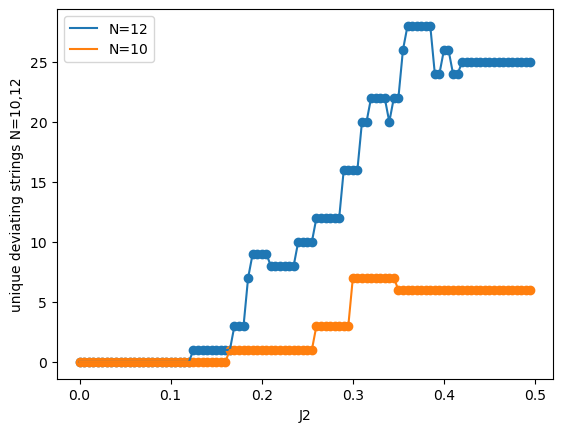

In [ ]:
plt.plot(J2s, len_uniques_12, label='N=12')
plt.scatter(J2s, len_uniques_12)
plt.plot(J2s, len_uniques, label = 'N=10')
plt.scatter(J2s, len_uniques)
plt.legend(loc = 'best')
plt.xlabel('J2')
plt.ylabel('unique deviating strings N=10,12')
plt.show()

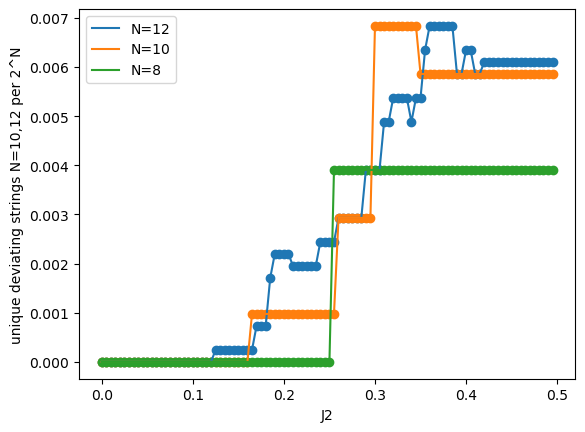

In [36]:
fraction_unique_8 = np.array(len_uniques_8) / (2**8)
fraction_unique_10 = np.array(len_uniques) / (2**10)
fraction_unique_12 = np.array(len_uniques_12) / (2**12)
plt.plot(J2s, fraction_unique_12, label='N=12')
plt.scatter(J2s, fraction_unique_12)
plt.plot(J2s, fraction_unique_10, label = 'N=10')
plt.scatter(J2s, fraction_unique_10)
plt.plot(J2s, fraction_unique_8, label='N=8')
plt.scatter(J2s, fraction_unique_8)
plt.legend(loc = 'best')
plt.xlabel('J2')
plt.ylabel('unique deviating strings N=10,12 per 2^N')
plt.show()

In [13]:
def rotate_right(state,rotations,N):
    return (2**N-1)&(state>>rotations|state<<(N-rotations))

In [14]:
uniques = find_uniques(dev_data_12[(12, 0.2)], N)
print(len(uniques))
for u in uniques:
    print(bin(u))

9
0b111111
0b1011111
0b1101111
0b1110111
0b1111011
0b1111101
0b10011111
0b11111001
0b100011111


In [15]:
uniques = find_uniques(dev_data_12[(12, 0.3)], N)
print(len(uniques))
for u in uniques:
    print(bin(u))

16
0b1011111
0b1101111
0b1110111
0b1111011
0b1111101
0b10011111
0b10101111
0b10110111
0b11001111
0b11101101
0b11110011
0b11110101
0b11111001
0b100011111
0b100101111
0b111101001


In [16]:
uniques = find_uniques(dev_data_12[(12, 0.4)], N)
print(len(uniques))
for u in uniques:
    print(bin(u))

26
0b1110111
0b10101111
0b10110111
0b10111011
0b11001111
0b11010111
0b11011011
0b11011101
0b11100111
0b11101011
0b11101101
0b11110011
0b11110101
0b100011111
0b100101111
0b100110111
0b100111011
0b100111101
0b101001111
0b101111001
0b110001111
0b110111001
0b111011001
0b111100101
0b111101001
0b1001001111


In [17]:
uniques = find_uniques(dev_data_12[(12, 0.495)], N)
print(len(uniques))
for u in uniques:
    print(bin(u))

25
0b111111
0b10101111
0b10110111
0b10111011
0b11001111
0b11010111
0b11011011
0b11011101
0b11100111
0b11101011
0b11101101
0b11110011
0b11110101
0b100101111
0b100110111
0b100111011
0b100111101
0b101001111
0b101111001
0b110001111
0b110111001
0b111011001
0b111100101
0b111101001
0b1001001111
